## LSTM Model

In [108]:
import glob
import pandas as pd
import numpy as np
from numpy import concatenate
from numpy import sqrt
import os

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import matplotlib.pyplot as plt

%matplotlib inline

In [63]:
def read_data(datafile):
    df_data = pd.read_csv(datafile, sep = ',')
    
    return df_data

In [64]:
fpath = "..\\data\\all_raw_files"
model_data_file = "model_data.csv"
model_data = read_data(f'{fpath}\{model_data_file}')

In [65]:
model_data

,Unnamed: 0,Year,Month,temp_mean,temp_min,temp_max,demand_mean,total_consumption,demand_max,demand_mean_max,pv_capacity,population,gsp
0,0,2010,1,20.868008,1.6,41.1,8941.450389,6554083.135,13765.04,10613.530000,28278.392,7110454,44504.250000
1,1,2010,2,20.218907,3.2,35.4,8855.467677,5831325.465,13377.27,10380.667857,32153.986,7119405,44504.250000
2,2,2010,3,19.828286,6.3,34.7,8698.725127,6319623.805,11991.47,10132.978710,38195.588,7128356,44504.250000
3,3,2010,4,17.593856,6.5,29.9,8452.863411,5984627.295,11436.13,9804.072333,45142.723,7133668,44504.250000
4,4,2010,5,15.323485,3.1,28.4,8897.770510,6459781.390,12386.49,10558.023548,54370.332,7138980,44504.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,139,2021,8,21.104167,16.9,30.7,7368.353056,530521.420,9043.62,8410.176667,3954209.744,8091356,57391.083333
140,140,2021,9,20.999306,14.2,27.5,7229.393819,520516.355,9206.19,8469.680000,4033918.477,8088503,57391.083333
141,141,2021,10,21.084722,14.8,26.9,7209.823194,519107.270,8841.21,8575.093333,4112353.036,8092743,57391.083333
142,142,2021,11,22.118056,15.7,27.3,7649.492569,550763.465,9573.70,9336.970000,4192992.282,8096983,57391.083333


## Decision on data to test, Temp_mean , pv_capacity, population ~ demand_mean_max

In [83]:
model_data_new = model_data[["temp_mean", "pv_capacity", "population", "demand_mean_max"]]
model_data_arr = model_data_new.values
model_data_arr
#Scale the model array
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(model_data_arr)
model_data_arr = scaler.transform(model_data_arr)
# Split training and testing data, testing data is last 24 months
model_data_x = model_data_arr[: , 0:-1]
model_data_y =  model_data_arr[: , -1]
lstm_train_x, lstm_test_x = model_data_x[0:-24 ], model_data_x[-24: ]
lstm_train_y, lstm_test_y  = model_data_y[0:-24 ], model_data_y[-24: ]

# reshape input to be 3D [samples, timesteps, features]
lstm_train_x = lstm_train_x.reshape((lstm_train_x.shape[0], 1, lstm_train_x.shape[1]))
lstm_test_x = lstm_test_x.reshape((lstm_test_x.shape[0], 1, lstm_test_x.shape[1]))
print(lstm_train_x.shape, lstm_train_y.shape, lstm_test_x.shape, lstm_test_y.shape)

(120, 1, 3) (120,) (24, 1, 3) (24,)


In [84]:
lstm_train_x

array([[[ 0.47859512, -1.        , -1.        ]],

       [[ 0.35846886, -0.99818183, -0.98212565]],

       [[ 0.28617855, -0.99534751, -0.9642513 ]],

       [[-0.12733724, -0.99208838, -0.95364371]],

       [[-0.54750442, -0.9877594 , -0.94303612]],

       [[-0.91396508, -0.98152703, -0.93242853]],

       [[-0.82474352, -0.97457749, -0.92015951]],

       [[-0.64828014, -0.96677098, -0.9078885 ]],

       [[-0.39198975, -0.95802332, -0.89561748]],

       [[-0.15665129, -0.94818275, -0.88419315]],

       [[ 0.17410876, -0.93692419, -0.87276683]],

       [[ 0.27655728, -0.92927149, -0.86134051]],

       [[ 0.68302912, -0.91638216, -0.84480209]],

       [[ 0.34999902, -0.90411922, -0.82826368]],

       [[ 0.19052677, -0.89067583, -0.81172526]],

       [[-0.25343106, -0.8795281 , -0.80254546]],

       [[-0.68290236, -0.86628497, -0.79336566]],

       [[-0.78282208, -0.85140791, -0.78418387]],

       [[-0.98201582, -0.84910329, -0.77020749]],

       [[-0.70204219, -0.847090

Epoch 1/50
1/1 - 2s - loss: 0.1421 - val_loss: 0.2589 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 0.1405 - val_loss: 0.2574 - 41ms/epoch - 41ms/step
Epoch 3/50
1/1 - 0s - loss: 0.1390 - val_loss: 0.2560 - 38ms/epoch - 38ms/step
Epoch 4/50
1/1 - 0s - loss: 0.1376 - val_loss: 0.2545 - 37ms/epoch - 37ms/step
Epoch 5/50
1/1 - 0s - loss: 0.1362 - val_loss: 0.2531 - 35ms/epoch - 35ms/step
Epoch 6/50
1/1 - 0s - loss: 0.1349 - val_loss: 0.2517 - 38ms/epoch - 38ms/step
Epoch 7/50
1/1 - 0s - loss: 0.1336 - val_loss: 0.2503 - 40ms/epoch - 40ms/step
Epoch 8/50
1/1 - 0s - loss: 0.1325 - val_loss: 0.2489 - 35ms/epoch - 35ms/step
Epoch 9/50
1/1 - 0s - loss: 0.1314 - val_loss: 0.2475 - 39ms/epoch - 39ms/step
Epoch 10/50
1/1 - 0s - loss: 0.1303 - val_loss: 0.2460 - 37ms/epoch - 37ms/step
Epoch 11/50
1/1 - 0s - loss: 0.1293 - val_loss: 0.2446 - 34ms/epoch - 34ms/step
Epoch 12/50
1/1 - 0s - loss: 0.1284 - val_loss: 0.2431 - 39ms/epoch - 39ms/step
Epoch 13/50
1/1 - 0s - loss: 0.1276 - val_loss: 0.241

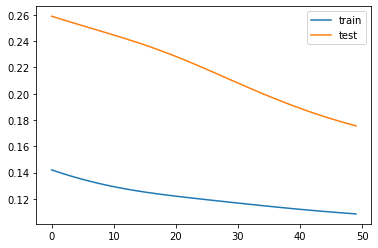

In [85]:
# Run model
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(lstm_train_x.shape[1], lstm_train_x.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(lstm_train_x, lstm_train_y, epochs=50, batch_size=124, validation_data=(lstm_test_x, lstm_test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [115]:
# make a prediction
yhat = model.predict(lstm_test_x)
lstm_test_sx = lstm_test_x.reshape((lstm_test_x.shape[0], lstm_test_x.shape[2]))
# invert scaling for forecast
inv_xyhat = concatenate((lstm_test_sx, yhat), axis=1)
inv_yyhat = scaler.inverse_transform(inv_xyhat)
inv_yhat = inv_yyhat[:,3]
# invert scaling for actual
lstm_test_sy = lstm_test_y.reshape((len(lstm_test_y), 1))
inv_sy = concatenate((lstm_test_sy, lstm_test_sy), axis=1)
inv_ty = concatenate((inv_sy, inv_sy), axis=1)
inv_wy = scaler.inverse_transform(inv_ty)
inv_y = inv_wy[:,3]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


1/1 [==============================] - 0s 28ms/step
Test RMSE: 664.600


In [118]:
inv_y

array([10149.83354839,  9311.35896552,  8817.48580645,  8982.185     ,
        9679.50612903, 10175.359     , 10394.69774194,  9764.8       ,
        9027.053     ,  8757.94032258,  9291.63633333,  8608.12129032,
        9666.57      ,  8568.18421053,  8304.00666667,  9185.06666667,
        9172.25      ,  7993.9       ,  8180.34      ,  8410.17666667,
        8469.68      ,  8575.09333333,  9336.97      ,  9784.83333333])

In [117]:
inv_yhat

array([9243.80943362, 9290.65402267, 9340.13380022, 9387.75558292,
       9504.40519798, 9557.97957206, 9546.99515753, 9523.41377985,
       9449.52381934, 9405.76736028, 9310.22354343, 9341.21332514,
       9219.42300914, 9287.70608014, 9330.93108424, 9268.02096353,
       9258.14140557, 9281.98998198, 9298.49251372, 9293.4064378 ,
       9299.81100608, 9296.81113877, 9262.56181858, 9214.28649741])